# 예측 오류 분석

submission 파일과 실제 정답(Y_test.csv)을 비교하여 틀린 데이터에 대한 분석을 진행합니다.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
sns.set_palette('husl')


In [13]:
# 파일 경로 설정
base_path = Path('/Users/jeong-uchang/USW-Big-Data-Analysis')
submission_path = base_path / 'final-assignment' / 'submissions' / 'submission_20251122_184927.csv'
y_test_path = base_path / '빅데이터분석_팀프로젝트3' / 'Y_test.csv'

# 데이터 로드
submission_df = pd.read_csv(submission_path)
y_test_df = pd.read_csv(y_test_path)

print(f"Submission 파일: {len(submission_df)} 행")
print(f"Y_test 파일: {len(y_test_df)} 행")
print(f"\nSubmission 컬럼: {submission_df.columns.tolist()}")
print(f"Y_test 컬럼: {y_test_df.columns.tolist()}")
print(f"\nSubmission 샘플:")
print(submission_df.head())
print(f"\nY_test 샘플:")
print(y_test_df.head())


Submission 파일: 2173 행
Y_test 파일: 2173 행

Submission 컬럼: ['ID', 'HE_D3_label']
Y_test 컬럼: ['ID', 'HE_D3_label']

Submission 샘플:
              ID  HE_D3_label
0  b'YO27274901'     0.245389
1  b'YA40446801'     0.447673
2  b'YA31291101'     0.781482
3  b'YF90453101'     0.218743
4  b'YH81313503'     0.224902

Y_test 샘플:
              ID  HE_D3_label
0  b'YO27274901'            0
1  b'YA40446801'            1
2  b'YA31291101'            1
3  b'YF90453101'            0
4  b'YH81313503'            0


In [14]:
# ID 정리 (b'...' 형식 제거)
def clean_id(id_str):
    if isinstance(id_str, str):
        # b'...' 형식에서 실제 ID 추출
        if id_str.startswith("b'"):
            return id_str[2:-1]  # b' 제거
        return id_str
    return str(id_str)

submission_df['ID_clean'] = submission_df['ID'].apply(clean_id)
y_test_df['ID_clean'] = y_test_df['ID'].apply(clean_id)

# ID로 병합
merged_df = pd.merge(
    submission_df[['ID_clean', 'HE_D3_label']],
    y_test_df[['ID_clean', 'HE_D3_label']],
    on='ID_clean',
    suffixes=('_pred', '_true')
)

print(f"병합된 데이터: {len(merged_df)} 행")
print(f"\n병합 데이터 샘플:")
print(merged_df.head(10))


병합된 데이터: 2173 행

병합 데이터 샘플:
     ID_clean  HE_D3_label_pred  HE_D3_label_true
0  YO27274901          0.245389                 0
1  YA40446801          0.447673                 1
2  YA31291101          0.781482                 1
3  YF90453101          0.218743                 0
4  YH81313503          0.224902                 0
5  YJ71222502          0.840943                 1
6  YF38248701          0.295087                 0
7  YJ62218401          0.745932                 1
8  YB27388201          0.228320                 1
9  YJ62244702          0.618703                 1


In [15]:
# 예측값을 이진 분류로 변환 (임계값 0.5)
merged_df['pred_binary'] = (merged_df['HE_D3_label_pred'] >= 0.5).astype(int)

# 오류 분석
merged_df['is_correct'] = merged_df['pred_binary'] == merged_df['HE_D3_label_true']
merged_df['error_type'] = 'Correct'
merged_df.loc[(merged_df['pred_binary'] == 0) & (merged_df['HE_D3_label_true'] == 1), 'error_type'] = 'False Negative (0->1)'
merged_df.loc[(merged_df['pred_binary'] == 1) & (merged_df['HE_D3_label_true'] == 0), 'error_type'] = 'False Positive (1->0)'

# 기본 통계
total = len(merged_df)
correct = merged_df['is_correct'].sum()
accuracy = correct / total

print(f"=" * 60)
print(f"전체 예측 결과 요약")
print(f"=" * 60)
print(f"전체 샘플 수: {total}")
print(f"정확한 예측: {correct} ({accuracy*100:.2f}%)")
print(f"틀린 예측: {total - correct} ({(1-accuracy)*100:.2f}%)")
print(f"\n오류 유형별 분포:")
print(merged_df['error_type'].value_counts())


전체 예측 결과 요약
전체 샘플 수: 2173
정확한 예측: 1493 (68.71%)
틀린 예측: 680 (31.29%)

오류 유형별 분포:
error_type
Correct                  1493
False Positive (1->0)     488
False Negative (0->1)     192
Name: count, dtype: int64


In [16]:
# 오류 유형별 상세 분석
error_df = merged_df[~merged_df['is_correct']].copy()

print(f"=" * 60)
print(f"오류 데이터 상세 분석")
print(f"=" * 60)
print(f"\n1. 오류 유형별 통계:")
error_summary = error_df.groupby('error_type').agg({
    'HE_D3_label_pred': ['count', 'mean', 'std', 'min', 'max'],
    'HE_D3_label_true': 'count'
}).round(4)
print(error_summary)

print(f"\n2. False Negative (0->1) 분석:")
fn_df = error_df[error_df['error_type'] == 'False Negative (0->1)']
print(f"   - 개수: {len(fn_df)}")
if len(fn_df) > 0:
    print(f"   - 예측 확률 평균: {fn_df['HE_D3_label_pred'].mean():.4f}")
    print(f"   - 예측 확률 중앙값: {fn_df['HE_D3_label_pred'].median():.4f}")
    print(f"   - 예측 확률 범위: [{fn_df['HE_D3_label_pred'].min():.4f}, {fn_df['HE_D3_label_pred'].max():.4f}]")

print(f"\n3. False Positive (1->0) 분석:")
fp_df = error_df[error_df['error_type'] == 'False Positive (1->0)']
print(f"   - 개수: {len(fp_df)}")
if len(fp_df) > 0:
    print(f"   - 예측 확률 평균: {fp_df['HE_D3_label_pred'].mean():.4f}")
    print(f"   - 예측 확률 중앙값: {fp_df['HE_D3_label_pred'].median():.4f}")
    print(f"   - 예측 확률 범위: [{fp_df['HE_D3_label_pred'].min():.4f}, {fp_df['HE_D3_label_pred'].max():.4f}]")


오류 데이터 상세 분석

1. 오류 유형별 통계:
                      HE_D3_label_pred                                  \
                                 count    mean     std     min     max   
error_type                                                               
False Negative (0->1)              192  0.3586  0.0999  0.1174  0.4999   
False Positive (1->0)              488  0.6853  0.1010  0.5002  0.8710   

                      HE_D3_label_true  
                                 count  
error_type                              
False Negative (0->1)              192  
False Positive (1->0)              488  

2. False Negative (0->1) 분석:
   - 개수: 192
   - 예측 확률 평균: 0.3586
   - 예측 확률 중앙값: 0.3777
   - 예측 확률 범위: [0.1174, 0.4999]

3. False Positive (1->0) 분석:
   - 개수: 488
   - 예측 확률 평균: 0.6853
   - 예측 확률 중앙값: 0.6907
   - 예측 확률 범위: [0.5002, 0.8710]


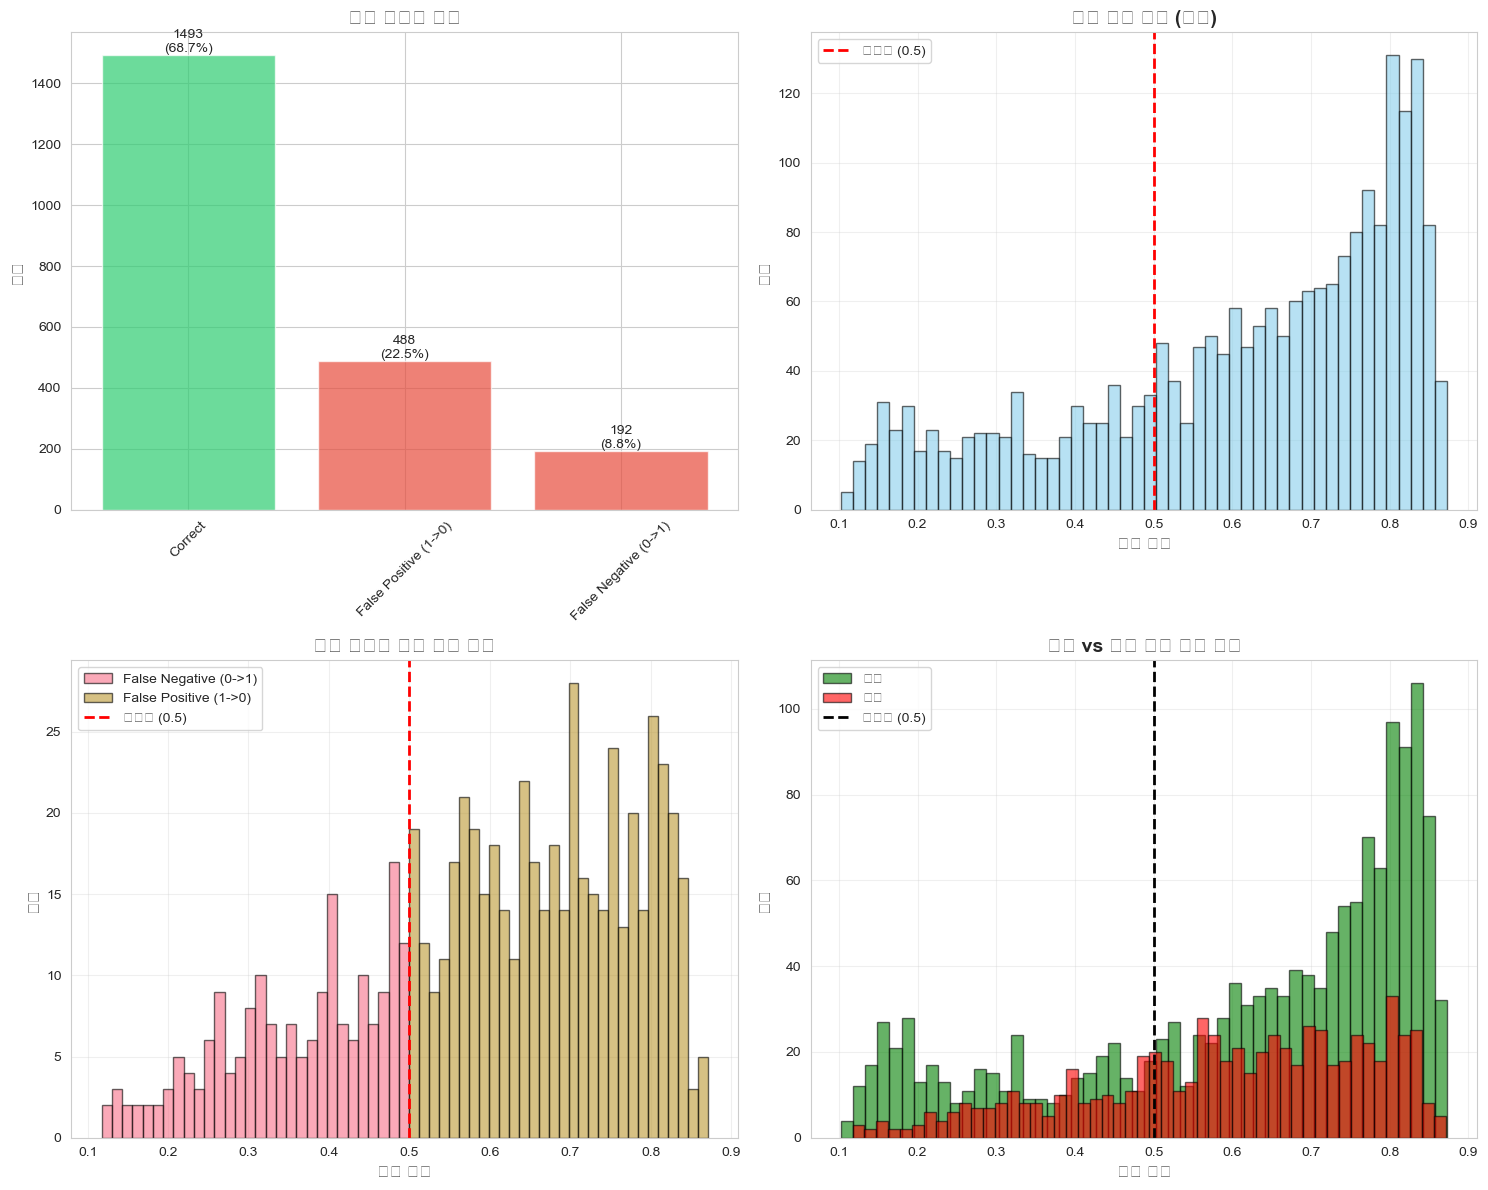

In [17]:
# 시각화 1: 오류 유형별 분포
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 오류 유형별 개수
ax1 = axes[0, 0]
error_counts = merged_df['error_type'].value_counts()
colors = ['#2ecc71' if x == 'Correct' else '#e74c3c' if 'False' in x else '#f39c12' for x in error_counts.index]
bars = ax1.bar(error_counts.index, error_counts.values, color=colors, alpha=0.7)
ax1.set_title('오류 유형별 분포', fontsize=14, fontweight='bold')
ax1.set_ylabel('개수', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/total*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# 2. 예측 확률 분포 (전체)
ax2 = axes[0, 1]
ax2.hist(merged_df['HE_D3_label_pred'], bins=50, alpha=0.6, color='skyblue', edgecolor='black')
ax2.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='임계값 (0.5)')
ax2.set_title('예측 확률 분포 (전체)', fontsize=14, fontweight='bold')
ax2.set_xlabel('예측 확률', fontsize=12)
ax2.set_ylabel('빈도', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 오류 유형별 예측 확률 분포
ax3 = axes[1, 0]
if len(error_df) > 0:
    for error_type in error_df['error_type'].unique():
        data = error_df[error_df['error_type'] == error_type]['HE_D3_label_pred']
        ax3.hist(data, bins=30, alpha=0.6, label=error_type, edgecolor='black')
ax3.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='임계값 (0.5)')
ax3.set_title('오류 유형별 예측 확률 분포', fontsize=14, fontweight='bold')
ax3.set_xlabel('예측 확률', fontsize=12)
ax3.set_ylabel('빈도', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 정답 vs 오답 예측 확률 비교
ax4 = axes[1, 1]
correct_probs = merged_df[merged_df['is_correct']]['HE_D3_label_pred']
error_probs = merged_df[~merged_df['is_correct']]['HE_D3_label_pred']
ax4.hist(correct_probs, bins=50, alpha=0.6, label='정답', color='green', edgecolor='black')
ax4.hist(error_probs, bins=50, alpha=0.6, label='오답', color='red', edgecolor='black')
ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='임계값 (0.5)')
ax4.set_title('정답 vs 오답 예측 확률 비교', fontsize=14, fontweight='bold')
ax4.set_xlabel('예측 확률', fontsize=12)
ax4.set_ylabel('빈도', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis_overview.png', dpi=300, bbox_inches='tight')
plt.show()


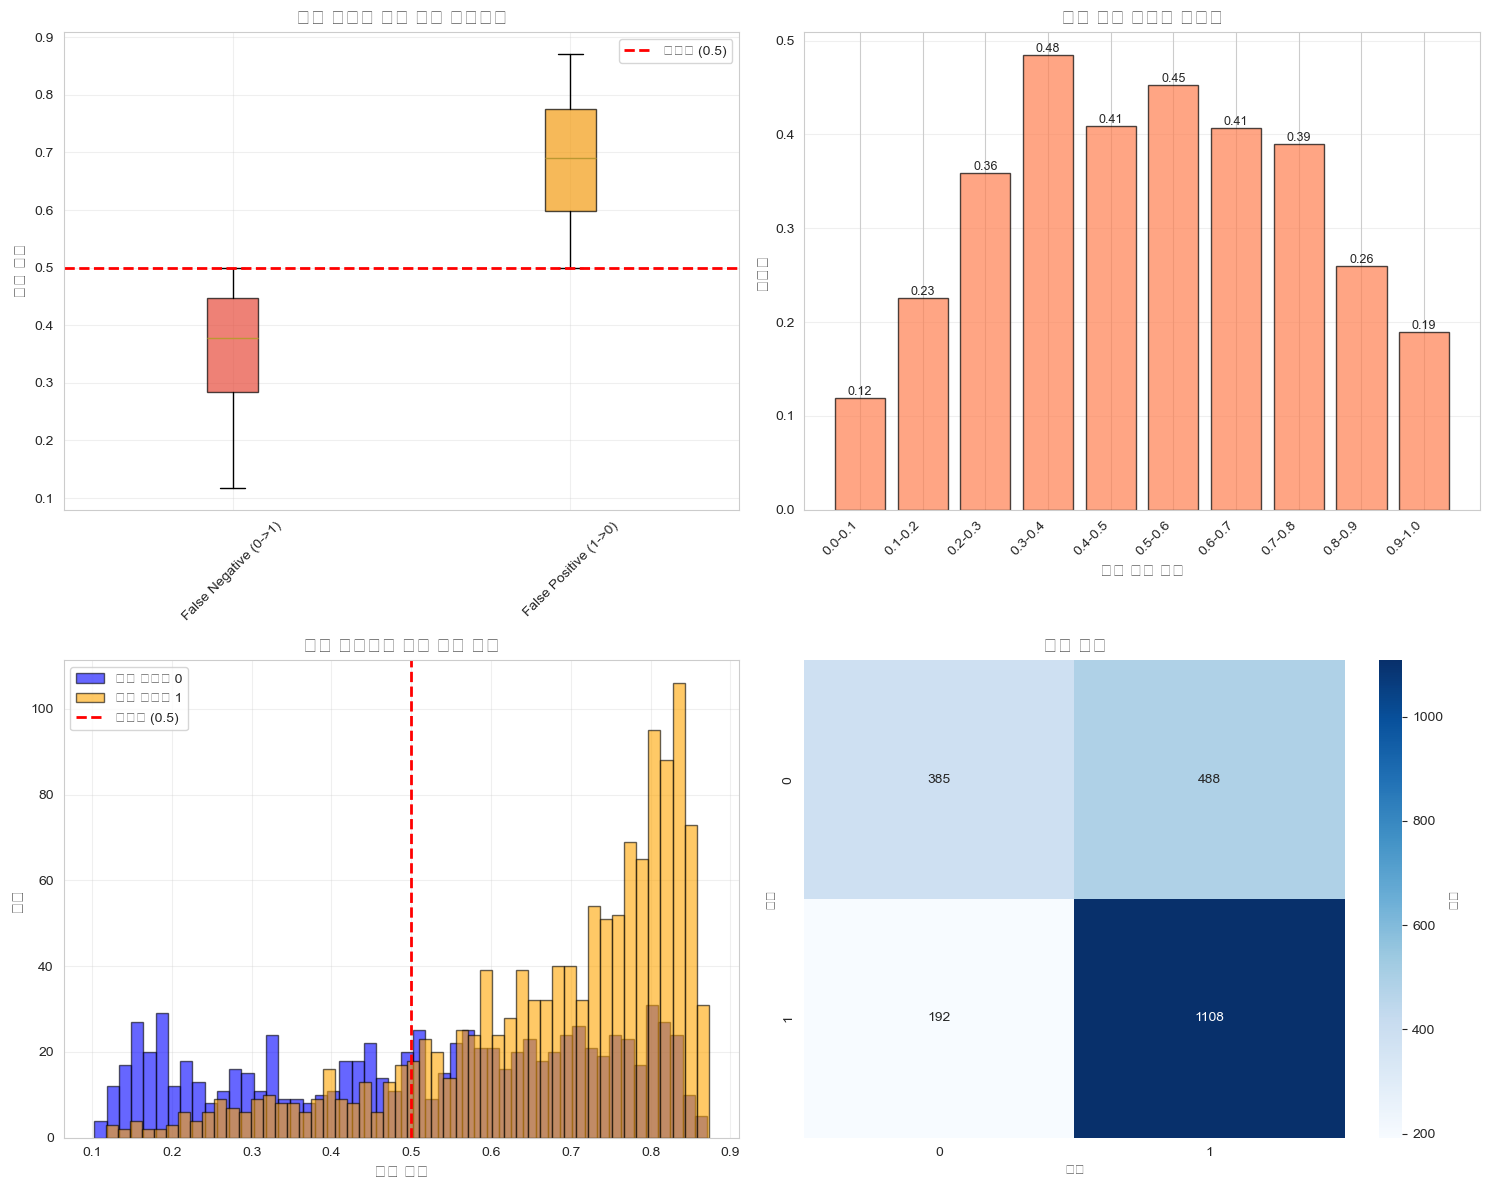

In [18]:
# 시각화 2: 상세 분석
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 오류 유형별 예측 확률 박스플롯
ax1 = axes[0, 0]
if len(error_df) > 0:
    error_types = error_df['error_type'].unique()
    box_data = [error_df[error_df['error_type'] == et]['HE_D3_label_pred'].values for et in error_types]
    bp = ax1.boxplot(box_data, labels=error_types, patch_artist=True)
    for patch, color in zip(bp['boxes'], ['#e74c3c', '#f39c12'][:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='임계값 (0.5)')
ax1.set_title('오류 유형별 예측 확률 박스플롯', fontsize=14, fontweight='bold')
ax1.set_ylabel('예측 확률', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 예측 확률 구간별 오류율
ax2 = axes[0, 1]
merged_df['prob_bin'] = pd.cut(merged_df['HE_D3_label_pred'], bins=10, labels=[f"{i*0.1:.1f}-{(i+1)*0.1:.1f}" for i in range(10)])
error_rate_by_bin = merged_df.groupby('prob_bin')['is_correct'].apply(lambda x: 1 - x.mean()).sort_index()
bars = ax2.bar(range(len(error_rate_by_bin)), error_rate_by_bin.values, alpha=0.7, color='coral', edgecolor='black')
ax2.set_xticks(range(len(error_rate_by_bin)))
ax2.set_xticklabels(error_rate_by_bin.index, rotation=45, ha='right')
ax2.set_title('예측 확률 구간별 오류율', fontsize=14, fontweight='bold')
ax2.set_xlabel('예측 확률 구간', fontsize=12)
ax2.set_ylabel('오류율', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# 3. 실제 레이블별 예측 확률 분포
ax3 = axes[1, 0]
true_0 = merged_df[merged_df['HE_D3_label_true'] == 0]['HE_D3_label_pred']
true_1 = merged_df[merged_df['HE_D3_label_true'] == 1]['HE_D3_label_pred']
ax3.hist(true_0, bins=50, alpha=0.6, label='실제 레이블 0', color='blue', edgecolor='black')
ax3.hist(true_1, bins=50, alpha=0.6, label='실제 레이블 1', color='orange', edgecolor='black')
ax3.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='임계값 (0.5)')
ax3.set_title('실제 레이블별 예측 확률 분포', fontsize=14, fontweight='bold')
ax3.set_xlabel('예측 확률', fontsize=12)
ax3.set_ylabel('빈도', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 혼동 행렬 스타일 시각화
ax4 = axes[1, 1]
confusion_data = pd.crosstab(merged_df['HE_D3_label_true'], merged_df['pred_binary'], 
                            rownames=['실제'], colnames=['예측'])
sns.heatmap(confusion_data, annot=True, fmt='d', cmap='Blues', ax=ax4, cbar_kws={'label': '개수'})
ax4.set_title('혼동 행렬', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('error_analysis_detailed.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# 임계값별 성능 분석
thresholds = np.arange(0.1, 1.0, 0.05)
results = []

for threshold in thresholds:
    pred_binary = (merged_df['HE_D3_label_pred'] >= threshold).astype(int)
    accuracy = (pred_binary == merged_df['HE_D3_label_true']).mean()
    
    # 혼동 행렬 계산
    tp = ((pred_binary == 1) & (merged_df['HE_D3_label_true'] == 1)).sum()
    tn = ((pred_binary == 0) & (merged_df['HE_D3_label_true'] == 0)).sum()
    fp = ((pred_binary == 1) & (merged_df['HE_D3_label_true'] == 0)).sum()
    fn = ((pred_binary == 0) & (merged_df['HE_D3_label_true'] == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    })

threshold_df = pd.DataFrame(results)

print("임계값별 성능 분석:")
print(threshold_df[['threshold', 'accuracy', 'precision', 'recall', 'f1']].round(4))

# 최적 임계값 찾기 (F1 점수 기준)
best_idx = threshold_df['f1'].idxmax()
best_threshold = threshold_df.loc[best_idx, 'threshold']
print(f"\n최적 임계값 (F1 기준): {best_threshold:.3f}")
print(f"해당 임계값에서의 성능:")
print(threshold_df.loc[best_idx, ['accuracy', 'precision', 'recall', 'f1']].round(4))


임계값별 성능 분석:
    threshold  accuracy  precision  recall      f1
0        0.10    0.5983     0.5983  1.0000  0.7486
1        0.15    0.6121     0.6071  0.9962  0.7544
2        0.20    0.6434     0.6282  0.9892  0.7684
3        0.25    0.6576     0.6401  0.9769  0.7734
4        0.30    0.6645     0.6489  0.9569  0.7734
5        0.35    0.6737     0.6605  0.9354  0.7743
6        0.40    0.6728     0.6655  0.9108  0.7691
7        0.45    0.6838     0.6817  0.8846  0.7700
8        0.50    0.6871     0.6942  0.8523  0.7652
9        0.55    0.6820     0.7056  0.8038  0.7515
10       0.60    0.6733     0.7242  0.7331  0.7286
11       0.65    0.6558     0.7400  0.6546  0.6947
12       0.70    0.6346     0.7603  0.5685  0.6505
13       0.75    0.5983     0.7858  0.4515  0.5735
14       0.80    0.5370     0.8168  0.2915  0.4297
15       0.85    0.4261     0.8955  0.0462  0.0878
16       0.90    0.4017     0.0000  0.0000  0.0000
17       0.95    0.4017     0.0000  0.0000  0.0000

최적 임계값 (F1 기준): 0.

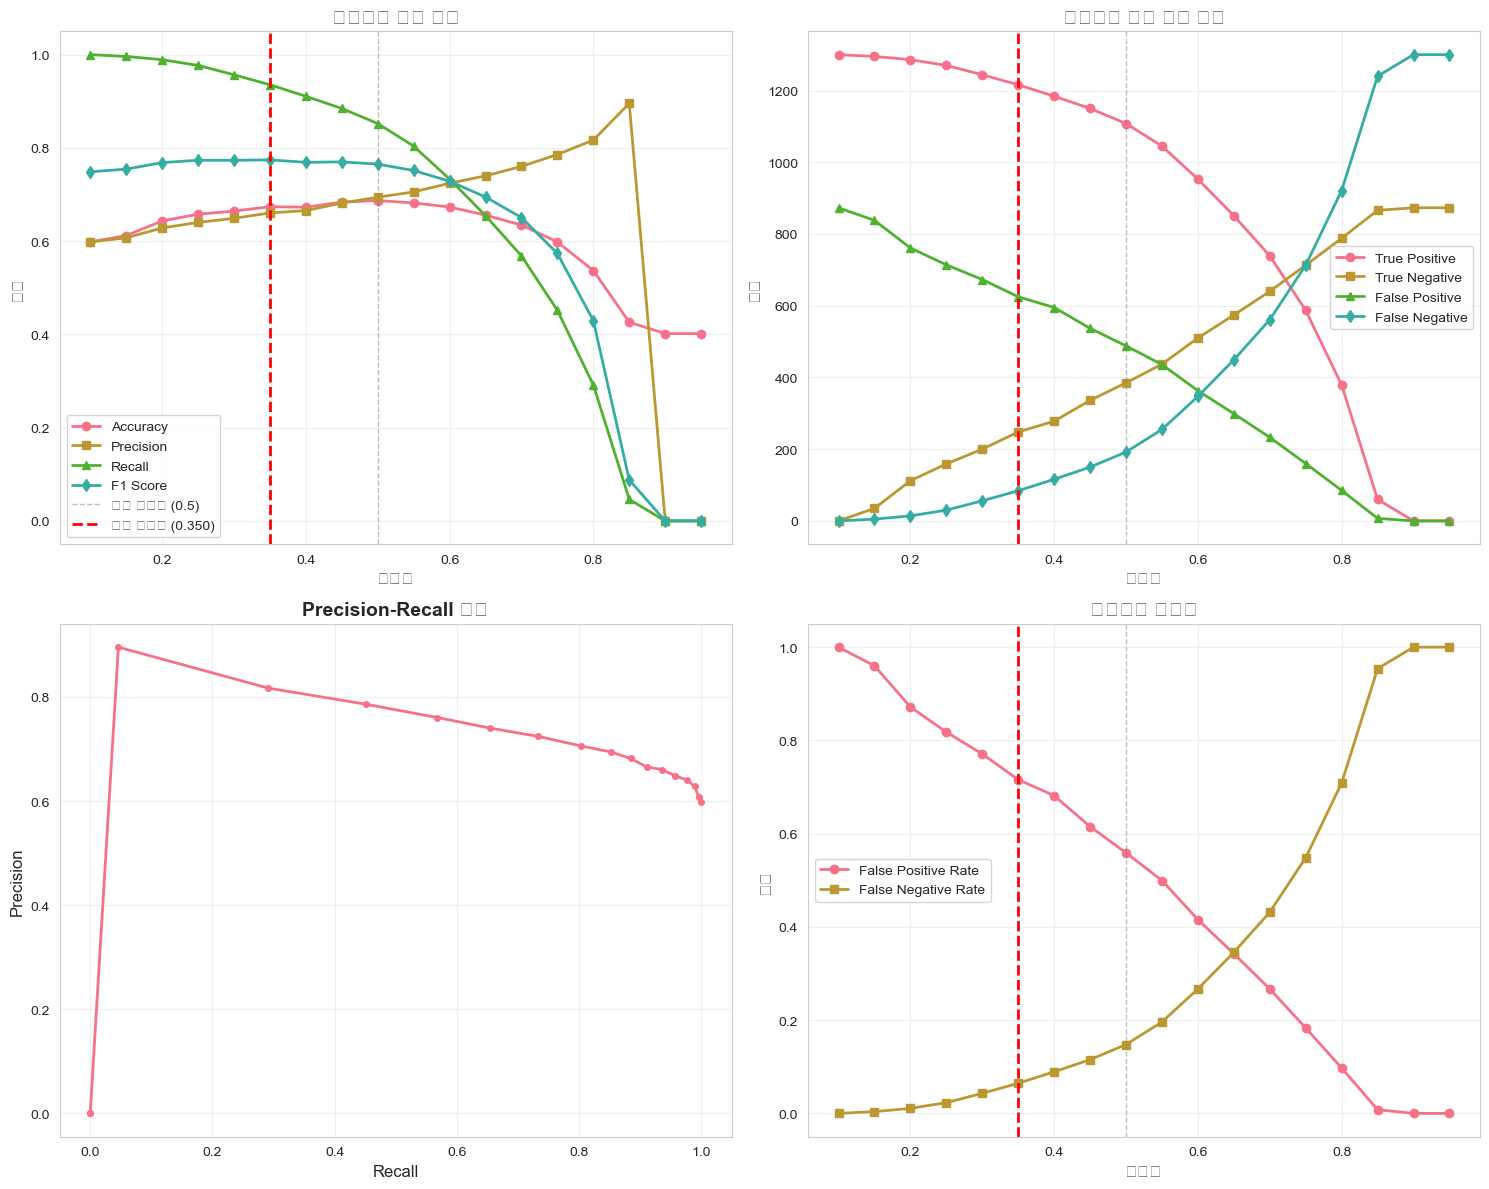

In [20]:
# 임계값별 성능 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 정확도, 정밀도, 재현율, F1 점수
ax1 = axes[0, 0]
ax1.plot(threshold_df['threshold'], threshold_df['accuracy'], label='Accuracy', marker='o', linewidth=2)
ax1.plot(threshold_df['threshold'], threshold_df['precision'], label='Precision', marker='s', linewidth=2)
ax1.plot(threshold_df['threshold'], threshold_df['recall'], label='Recall', marker='^', linewidth=2)
ax1.plot(threshold_df['threshold'], threshold_df['f1'], label='F1 Score', marker='d', linewidth=2)
ax1.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='현재 임계값 (0.5)')
ax1.axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, label=f'최적 임계값 ({best_threshold:.3f})')
ax1.set_xlabel('임계값', fontsize=12)
ax1.set_ylabel('점수', fontsize=12)
ax1.set_title('임계값별 성능 지표', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 혼동 행렬 요소별 변화
ax2 = axes[0, 1]
ax2.plot(threshold_df['threshold'], threshold_df['tp'], label='True Positive', marker='o', linewidth=2)
ax2.plot(threshold_df['threshold'], threshold_df['tn'], label='True Negative', marker='s', linewidth=2)
ax2.plot(threshold_df['threshold'], threshold_df['fp'], label='False Positive', marker='^', linewidth=2)
ax2.plot(threshold_df['threshold'], threshold_df['fn'], label='False Negative', marker='d', linewidth=2)
ax2.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.axvline(x=best_threshold, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('임계값', fontsize=12)
ax2.set_ylabel('개수', fontsize=12)
ax2.set_title('임계값별 혼동 행렬 요소', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. ROC 스타일: Precision-Recall 곡선
ax3 = axes[1, 0]
ax3.plot(threshold_df['recall'], threshold_df['precision'], marker='o', linewidth=2, markersize=4)
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision-Recall 곡선', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. 오류율 비교
ax4 = axes[1, 1]
fp_rate = threshold_df['fp'] / (threshold_df['fp'] + threshold_df['tn'])
fn_rate = threshold_df['fn'] / (threshold_df['fn'] + threshold_df['tp'])
ax4.plot(threshold_df['threshold'], fp_rate, label='False Positive Rate', marker='o', linewidth=2)
ax4.plot(threshold_df['threshold'], fn_rate, label='False Negative Rate', marker='s', linewidth=2)
ax4.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=best_threshold, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('임계값', fontsize=12)
ax4.set_ylabel('비율', fontsize=12)
ax4.set_title('임계값별 오류율', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis_threshold.png', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
# 가장 큰 오류를 보이는 샘플 분석
print("=" * 60)
print("큰 오류를 보이는 샘플 분석")
print("=" * 60)

# False Negative 중 예측 확률이 가장 낮은 것들 (실제로는 1인데 0으로 예측)
fn_samples = error_df[error_df['error_type'] == 'False Negative (0->1)'].copy() if len(error_df) > 0 else pd.DataFrame()
if len(fn_samples) > 0:
    fn_samples = fn_samples.sort_values('HE_D3_label_pred').head(20)
    print(f"\n1. False Negative (실제=1, 예측=0) - 예측 확률이 가장 낮은 20개:")
    print(fn_samples[['ID_clean', 'HE_D3_label_pred', 'HE_D3_label_true']].to_string(index=False))

# False Positive 중 예측 확률이 가장 높은 것들 (실제로는 0인데 1로 예측)
fp_samples = error_df[error_df['error_type'] == 'False Positive (1->0)'].copy() if len(error_df) > 0 else pd.DataFrame()
if len(fp_samples) > 0:
    fp_samples = fp_samples.sort_values('HE_D3_label_pred', ascending=False).head(20)
    print(f"\n2. False Positive (실제=0, 예측=1) - 예측 확률이 가장 높은 20개:")
    print(fp_samples[['ID_clean', 'HE_D3_label_pred', 'HE_D3_label_true']].to_string(index=False))

# 경계선 근처의 오류 (0.4~0.6 사이)
if len(error_df) > 0:
    boundary_errors = error_df[
        (error_df['HE_D3_label_pred'] >= 0.4) & 
        (error_df['HE_D3_label_pred'] <= 0.6)
    ].copy()
    
    print(f"\n3. 경계선 근처 오류 (0.4 <= 예측 확률 <= 0.6): {len(boundary_errors)}개")
    if len(boundary_errors) > 0:
        print(boundary_errors.groupby('error_type').size())


큰 오류를 보이는 샘플 분석

1. False Negative (실제=1, 예측=0) - 예측 확률이 가장 낮은 20개:
  ID_clean  HE_D3_label_pred  HE_D3_label_true
YH74390404          0.117396                 1
YA86358002          0.129632                 1
YD89523901          0.130778                 1
YE01388201          0.138525                 1
YB26351802          0.140840                 1
YH60248805          0.154635                 1
YA17214302          0.155232                 1
YN90269001          0.158864                 1
YR38254703          0.162086                 1
YA67210303          0.174304                 1
YN14357802          0.177013                 1
YE62420703          0.187745                 1
YO39529704          0.189181                 1
YH64402502          0.195624                 1
YH77238703          0.201993                 1
YA82436901          0.203021                 1
YH77364101          0.208813                 1
YH86394402          0.211927                 1
YH82317604          0.214395           

In [23]:
# 결과 저장
output_dir = Path('results')
output_dir.mkdir(exist_ok=True)

# 오류 데이터 저장
if len(error_df) > 0:
    error_df[['ID_clean', 'HE_D3_label_pred', 'HE_D3_label_true', 'pred_binary', 'error_type']].to_csv(
        output_dir / 'error_samples.csv', index=False, encoding='utf-8-sig'
    )

# NumPy 타입을 Python 기본 타입으로 변환하는 함수
def convert_to_native_type(value):
    """NumPy 타입을 Python 기본 타입으로 변환"""
    if isinstance(value, (np.integer, np.int64, np.int32)):
        return int(value)
    elif isinstance(value, (np.floating, np.float64, np.float32)):
        return float(value)
    elif isinstance(value, np.ndarray):
        return value.tolist()
    return value

# 요약 통계 저장 (NumPy 타입을 Python 기본 타입으로 변환)
summary_stats = {
    'total_samples': int(len(merged_df)),
    'correct_predictions': int(merged_df['is_correct'].sum()),
    'accuracy': float(accuracy),
    'false_negative_count': int(len(fn_df)) if len(error_df) > 0 and len(fn_df) > 0 else 0,
    'false_positive_count': int(len(fp_df)) if len(error_df) > 0 and len(fp_df) > 0 else 0,
    'false_negative_mean_prob': float(fn_df['HE_D3_label_pred'].mean()) if len(error_df) > 0 and len(fn_df) > 0 else 0.0,
    'false_positive_mean_prob': float(fp_df['HE_D3_label_pred'].mean()) if len(error_df) > 0 and len(fp_df) > 0 else 0.0,
    'best_threshold': float(best_threshold),
    'best_f1': float(threshold_df.loc[best_idx, 'f1'])
}

import json
with open(output_dir / 'error_analysis_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)

print("분석 결과가 저장되었습니다:")
print(f"- 오류 샘플: {output_dir / 'error_samples.csv'}")
print(f"- 요약 통계: {output_dir / 'error_analysis_summary.json'}")
print(f"- 시각화: error_analysis_overview.png, error_analysis_detailed.png, error_analysis_threshold.png")


분석 결과가 저장되었습니다:
- 오류 샘플: results/error_samples.csv
- 요약 통계: results/error_analysis_summary.json
- 시각화: error_analysis_overview.png, error_analysis_detailed.png, error_analysis_threshold.png
